In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [101]:
using DifferentialEquations, Plots, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, QuadGK

In [3]:
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
data_dir = "pixel_data/"
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [11]:
q, ylocal, pt = get_samples(file_pairs[1:1]);

In [12]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [13]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [14]:
args = Args(batchsize = 128)

test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [15]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [20]:
yfn = t -> ylocal_to_current(t, xl, sa)

#37 (generic function with 1 method)

In [21]:
n_px = size(x, 2) 
n_in = n_px + 1
#n_in = n_px

14

In [22]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [23]:
x_tms = range(start=0.0, stop=1.0, length=size(x, 1)) |> collect;
current_fn = t -> sum(interpolate_2D(t, x_tms, x), dims=2)[:,1,:]

#39 (generic function with 1 method)

In [24]:
current_fn(0.5)

13×128 Matrix{Float64}:
    0.0      0.0      0.0      0.0   …     0.0      0.0       0.0      0.0
    0.0      0.0      0.0      0.0         0.0      0.0       0.0      0.0
    0.0    630.0      1.0      0.0        -2.15     0.0      75.0      0.0
  752.0   3508.0    906.0   1688.0      1135.85     0.0    7222.25  1332.0
 2029.0   4032.3   2225.0   6516.1      9516.85    -0.2   12422.9   5733.2
 2563.65  3834.1   3011.1   5575.75  …    -4.0   2924.65   5095.05  6892.9
 2356.25  1584.1   3205.2   9595.7         0.0   6867.65     -0.2   3484.9
 1706.25    -0.15  1146.2    -70.15        0.0     20.8       0.0     -0.3
 1085.65     0.0     -0.95     0.0         0.0      0.0       0.0      0.0
    0.0      0.0      0.0      0.0         0.0      0.0       0.0      0.0
    0.0      0.0      0.0      0.0   …     0.0      0.0       0.0      0.0
    0.0      0.0      0.0      0.0         0.0      0.0       0.0      0.0
    0.0      0.0      0.0      0.0         0.0      0.0       0.0      0.0

In [25]:
ts = 0.0:0.001:1.0
current_sample = stack(current_fn.(ts), dims=1);

In [26]:
current_sample |> size

(1001, 13, 128)

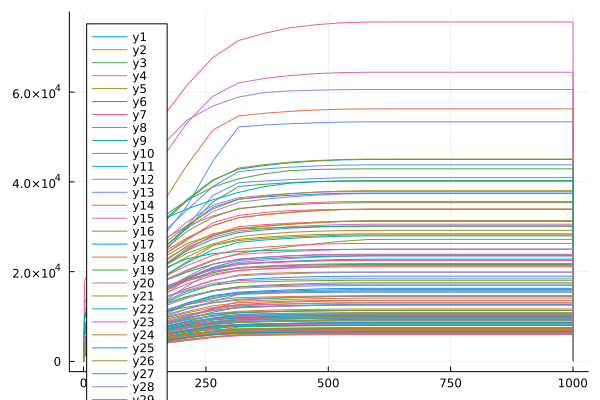

In [27]:
plot(dropdims(sum(current_sample, dims=(2)), dims=(2)))

In [28]:
function process_inputs(x::AbstractArray, y_local::AbstractArray, spk_args::SpikingArgs)
    v_fn = t -> sum(scale_charge(interpolate_2D(t, x_tms, x)), dims=2)[:,1,:]
    y_fn = t -> ylocal_to_current(t, y_local, spk_args)

    x_fn = t -> cat(v_fn(t), reshape(y_fn(t), (1,:)), dims=1)
    return x_fn
end

process_inputs (generic function with 1 method)

In [29]:
fn0 = process_inputs(x, xl, sa)

#43 (generic function with 1 method)

In [30]:
fn0(0.5)

14×128 Matrix{Float64}:
 0.0           0.0          0.0          …   0.0          0.0        0.0
 0.0           0.0          0.0              0.0          0.0        0.0
 0.0           0.252        0.0004           0.0          0.03       0.0
 0.3008        1.4032       0.3624           0.0          2.8889     0.5328
 0.8116        1.61292      0.89            -8.0e-5       4.96916    2.29328
 1.02546       1.53364      1.20444      …   1.16986      2.03802    2.75716
 0.9425        0.63364      1.28208          2.74706     -8.0e-5     1.39396
 0.6825       -6.0e-5       0.45848          0.00832      0.0       -0.00012
 0.43426       0.0         -0.00038          0.0          0.0        0.0
 0.0           0.0          0.0              0.0          0.0        0.0
 0.0           0.0          0.0          …   0.0          0.0        0.0
 0.0           0.0          0.0              0.0          0.0        0.0
 0.0           0.0          0.0              0.0          0.0        0.0
 4.16157

In [31]:
ode_fn = Chain(BatchNorm(n_in),
                x -> tanh.(x),
                Dense(n_in => 128))

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction(#47),
    layer_3 = Dense(14 => 128),         # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [32]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [33]:
in_ps, in_st = Lux.setup(rng, ode_fn)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [34]:
ifn = t -> scale_charge(current_fn(t))

#49 (generic function with 1 method)

In [35]:
smp = fn0(0.01);

In [36]:
size(smp)

(14, 128)

In [37]:
smp1, _ = ode_fn(smp, in_ps, in_st)

([0.07739081912167091 0.0881402785942401 … 0.07692436410752301 0.018052638863612275; 0.21619972842671217 -0.05266935229307393 … -0.3137510132962408 0.002916165622680846; … ; 0.12042696431037019 0.03781258380523473 … 0.10291563350052708 0.03503888259961364; -0.054889462080378634 0.12463202581318926 … -0.1333874357527193 0.2666393084563043], (layer_1 = (running_mean = [0.0, 0.0, 5.776750086080282e-5, 0.003946564433808392, 0.026867073837850586, 0.05181607420961967, 0.06451670939887386, 0.03794924712798785, 0.0012283809558043034, -0.0010373459529576592, -0.00013816156455876774, 0.0, 0.0, 9.223345394625637e-150], running_var = [0.8999999761581421, 0.8999999761581421, 0.9000032382141888, 0.9011405877654486, 0.9329395060189734, 0.9514999612802623, 1.0130310443121386, 0.9650273319633302, 0.9049636320145709, 0.9001705356023475, 0.9000244095887173, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [38]:
smp1 |> size

(128, 128)

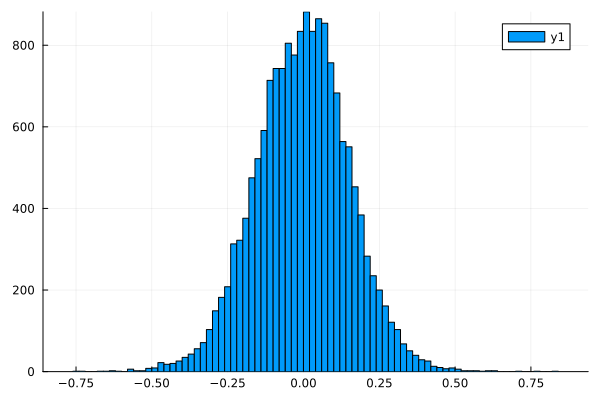

In [39]:
histogram(vec(smp1))

In [40]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)[:,:,end]),
                PhasorDenseF32(128 => 3))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction(#47),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction(#51),
    layer_3 = PhasorDenseF32((3, 128)),  # 390 parameters
)         # Total: 2_338 parameters,
          #        plus 29 states.

In [41]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.13161425 0.064619735 … -0.0023485615 0.11421584; -0.031960584 -0.08069022 … 0.16133843 0.055274427; … ; 0.11458632 -0.17766307 … 0.07918862 0.08826637; -0.07798973 -0.18868946 … -0.11480703 -0.052110754], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true

In [42]:
out1, st1 = ode_model(fn0, ps, st)

(Float32[-0.48170412 -0.50432473 … -0.7967186 0.4563719; 0.43017688 -0.20135935 … -0.34815136 0.60701466; -0.80890006 0.0021870884 … 0.22318947 -0.12059302], (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [43]:
out1

3×128 Matrix{Float32}:
 -0.481704  -0.504325    -0.296904  …  -0.322565  -0.796719   0.456372
  0.430177  -0.201359     0.550991     -0.715554  -0.348151   0.607015
 -0.8089     0.00218709   0.268643     -0.929549   0.223189  -0.120593

In [44]:
u1 = Array(out1)

3×128 Matrix{Float32}:
 -0.481704  -0.504325    -0.296904  …  -0.322565  -0.796719   0.456372
  0.430177  -0.201359     0.550991     -0.715554  -0.348151   0.607015
 -0.8089     0.00218709   0.268643     -0.929549   0.223189  -0.120593

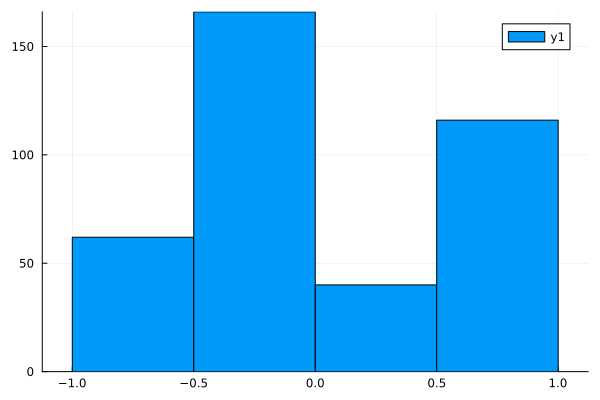

In [45]:
histogram(vec(u1))

In [46]:
#calc a gradient through a loss fn on the network

In [47]:
using Statistics: mean

In [51]:
ps

(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.13161425 0.064619735 … -0.0023485615 0.11421584; -0.031960584 -0.08069022 … 0.16133843 0.055274427; … ; 0.11458632 -0.17766307 … 0.07918862 0.08826637; -0.07798973 -0.18868946 … -0.11480703 -0.052110754], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [52]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = Float32[], layer_3 = (weight = Float32[0.13161425 0.064619735 … -0.0023485615 0.11421584; -0.031960584 -0.08069022 … 0.16133843 0.055274427; … ; 0.11458632 -0.17766307 … 0.07918862 0.08826637; -0.07798973 -0.18868946 … -0.11480703 -0.052110754], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [57]:
using OneHotArrays

In [58]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [59]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [60]:
l1 = momentum_to_label(pt)

3×49997 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  1  1  1  1  ⋅  1  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  1  ⋅  1  1

In [61]:
function loss(x, xl, y, model, ps, st, threshold)
    drive_fn = process_inputs(x, xl, sa)
    y_pred, st = model(drive_fn, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [62]:
l1, st1 = loss(x, xl, y, ode_model, psa, st, 0.2)

(0.9812606824094384, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [63]:
@time withgradient(p -> loss(x, xl, y, ode_model, p, st, 0.2), psa)

  3.230157 seconds (3.13 M allocations: 5.049 GiB, 25.80% gc time, 48.59% compilation time)


(val = (0.9812606838675939, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())), grad = ((layer_1 = (layer_1 = (scale = Float32[-0.0010231362, -0.005794042, 0.0040571406, 0.029073002, -0.035243362, 0.02476147, -0.026974132, -0.00027003884, 0.031925865, -0.041952156, 0.02621654, 0.0, 0.0, 0.070311375], bias = Float32[-0.0060500284, 0.050109003, 0.1336648, -0.064165525, -0.089627534, -0.015218141, -0.1787807, -0.17677169, -0.03785465, 0.01881097, 0.02446481, -0.017380778, -0.034754254, 0.1338503]), layer_2 = Float32[], layer_3 = (weight = Float32[0.0018569751 -0.009194359 … 0.0 0.017338714; -0.0042579235 -0.009101569 … 0.0 -0.09775181; … ; 0.006745414 0.025547652 … 0.0 0.089236334; 0.0021015978 -0.001234362 … 0.

In [64]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            #print(i)
            #i += 1
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [169]:
@time lhist, pst, stt = train(ode_model, psa, st, train_loader)

01

[ Info: Constructing model and starting training


2345678910111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989910010110210310410510610710810911011111211311411511611711811912012112212312412512612712812913013113213313413513613713813914014114214314414514614714814915015115215315415515615715815916016116216316416516616716816917017117217317417517617717817918018118218318418518618718818919019119219319419519619719819920020120220320420520620720820921021121221321421521621721821922022122222322422522622722822923023123223323423523623723823924024124224324424524624724824925025125225325425525625725825926026126226326426526626726826927027127227327427527627727827928028128228328428528628728828929029129229329429529629729829930030130230330430530630730830931031131231331431531631731831932032132232332432532632732832933033133233333433533633733833934034134234334434534634734834935035135235335435535635735835936036136236336436536636736836937

(Any[0.39245644321048556, 0.23935790186334996, 0.22434045439013098, 0.21771411059721518, 0.2135464670463863, 0.21064925817699173, 0.2083901430807517, 0.20644176513237156, 0.20490212375942118, 0.2033144051813218], (layer_1 = (layer_1 = (scale = Float32[0.985888, 0.9758947, 1.0515486, 0.9367691, 0.88969547, 0.95883083, 0.9546232, 1.0493257, 0.9393127, 1.0129439, 0.91896284, 0.8823252, 0.9319464, 1.2807451], bias = Float32[0.06363973, -0.0034156404, -0.017854506, 0.0726833, 0.04317411, 0.05108157, 0.04118271, 0.12044012, 0.03257529, -0.15979461, -0.15202409, -0.002650196, 0.065109454, 0.32932743]), layer_2 = Float32[], layer_3 = (weight = Float32[0.14446877 0.028428206 … 0.015889607 0.088466845; -0.059218623 -0.05544821 … 0.11826347 0.0755178; … ; 0.08999296 -0.08419553 … 0.06512411 0.042705365; -0.01944074 -0.093102925 … -0.12677124 -0.05322558], bias = Float32[0.085599735; 0.13215777; … ; -0.15275422; 0.1200016;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.6800914 -0.1164529

In [170]:
lhist

10-element Vector{Any}:
 0.39245644321048556
 0.23935790186334996
 0.22434045439013098
 0.21771411059721518
 0.2135464670463863
 0.21064925817699173
 0.2083901430807517
 0.20644176513237156
 0.20490212375942118
 0.2033144051813218

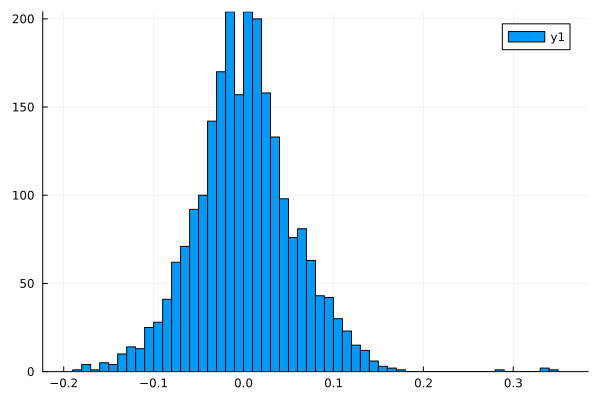

In [183]:
histogram(vec(pst .- psa))

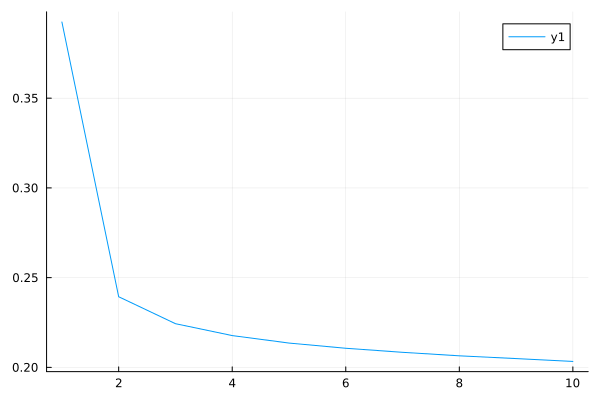

In [171]:
plot(lhist)

In [65]:
using JLD2

In [172]:
jldsave("ode_params.jld2"; params = pst, state = stt)

In [ ]:
jldsave("ode_params.jld2"; params = pst, state = stt)

In [67]:
t50 = jldopen("parameters/epoch_50.jld2")

JLDFile /Users/wilkie/code/phasor_julia/parameters/epoch_50.jld2 (read-only)
 ├─🔢 params
 └─🔢 state

In [70]:
pst = t50["params"]
stt = t50["state"]

(layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [71]:
sttf = Lux.testmode(stt)

(layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [72]:
loss(x, xl, y, ode_model, pst, sttf, 0.2)

(0.4394735776530506, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

# Calculate Test Loss

In [73]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [82]:
function compare_prediction(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    drive_fn = process_inputs(x, xl, sa)
    y_pred, _ = model(drive_fn, ps, st)
    y_labels = predict_quadrature(y_pred) .- 1
    return y_pred, y_truth, y_labels
end

compare_prediction (generic function with 1 method)

In [83]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    drive_fn = process_inputs(x, xl, sa)
    y_pred, _ = model(drive_fn, ps, st)
    y_labels = predict_quadrature(y_pred) .- 1
    #return y_truth, y_labels
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [76]:
accuracy(xts, xlts, yts, ode_model, pst, stt, 0.2)

85

In [92]:
yth1, yt1, yp1 = compare_prediction(q_test[:,:,:,1:1024], ylocal_test[1:1024], pt_test[1:1024], ode_model, pst, stt, 0.2)

(Float32[0.0150109865 0.029765079 … -0.0021843999 -0.01692568; -0.035043314 0.07177453 … 0.30653453 0.012207081; 0.39312306 0.34428117 … 0.23607932 0.43597317], [0, 2, 1, 2, 1, 2, 1, 1, 0, 0  …  1, 2, 2, 1, 2, 2, 1, 1, 2, 2], [2; 2; … ; 1; 2;;])

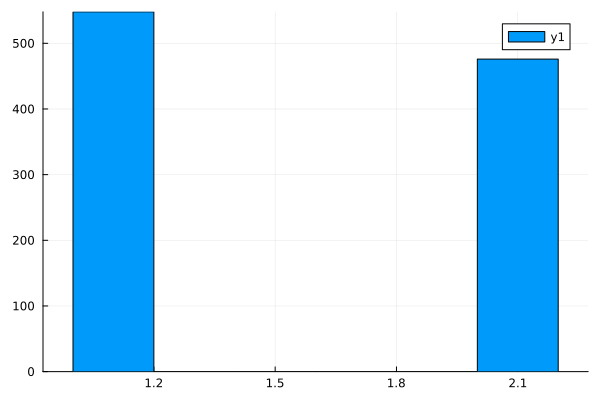

In [93]:
histogram(yp1 |> vec)

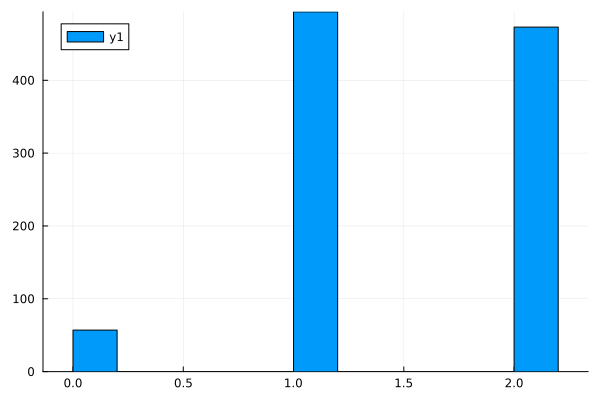

In [94]:
histogram(yt1)

In [80]:
accuracy(q_test[:,:,:,1:1024], ylocal_test[1:1024], pt_test[1:1024], ode_model, pst, stt, 0.2)

693

In [95]:
yth1

3×1024 Matrix{Float32}:
  0.015011   0.0297651  -0.00402847  …  -0.0048071  -0.0021844  -0.0169257
 -0.0350433  0.0717745   0.445521        0.21946     0.306535    0.0122071
  0.393123   0.344281   -0.031529        0.222219    0.236079    0.435973

In [97]:
roc = tpr_fpr(yth1, pt_test[1:1024])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [98]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

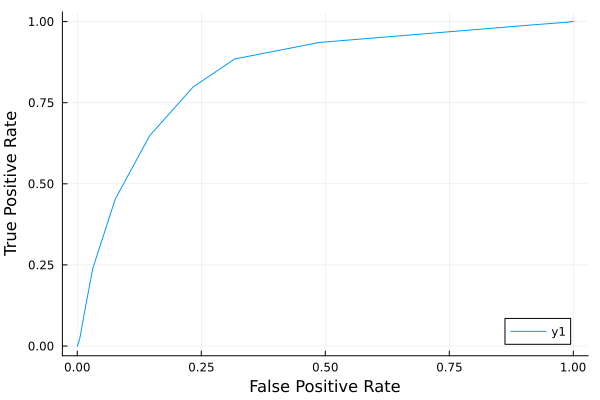

In [99]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [102]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8421499688287084, 1.2136258769092238e-8)